In [22]:
# Import Data Preprocessing and Wrangling libraries
import re
from tqdm.notebook import tqdm
import pandas as pd 
import numpy as np
from datetime import datetime

# Import NLP Libraries
import nltk
import sklearn
import tensorflow
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

# Import Visualization Libraries
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random 
import seaborn as sns

# Downloading periphrals
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xingyuchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# define function to clean tweets
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    # lowercase all the letters
    temp = tweet.lower()
    
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    
    # remove hashtages and mentions
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    
    # remove links
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub(r"www.\S+", "", temp)
    
    # remove punctuations
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    
    # flitering non-alphanumeric characters
    temp = re.sub("[^a-z0-9]"," ", temp)
    
    # remove stop word
    temp = temp.split()
    temp = [w for w in temp if not w in stop_words]
    
    # put text into a list 
    temp = " ".join(word for word in temp)
    return temp

In [10]:
# import dataset and check
df = pd.read_csv('data/prochoice_prolife.csv')
df.head()

,Unnamed: 0,author_id,author_name,author_username,created_at,id,public_metrics,text,retweet_count,like_count,target
0,28588,73506221,Oregon Right to Life,OR_RTL,2022-06-23 00:00:06+00:00,1539760170900799490,"{'retweet_count': 5, 'reply_count': 0, 'like_c...",We know that unsupported pregnancies can gener...,5,13,1
1,28587,96631851,αιяgσ*мαтι¢*σρтιχ,sacraficial,2022-06-23 00:01:14+00:00,1539760456977395712,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",If you are murdered by a George W. Bush weapon...,0,0,1
2,28586,3041829701,skb,skb37027,2022-06-23 00:04:30+00:00,1539761277702213633,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",.@MarshaBlackburn so much for #ProLife. https:...,0,0,1
3,28537,177260708,Right To Life League,Right2LifeLg,2022-06-23 00:09:50+00:00,1539762620055552001,"{'retweet_count': 6, 'reply_count': 3, 'like_c...",Follow our instagram for more posts like this!...,6,19,1
4,27450,1523376591052582912,No Forced Birth,NoForcedBirth,2022-06-23 00:09:57+00:00,1539762647922421763,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Another classy tweet from the forced birth cro...,0,1,0


In [11]:
# Select useful columns
df = df[['created_at', 'text', 'retweet_count', 'like_count', 'target']]
df.head()

,created_at,text,retweet_count,like_count,target
0,2022-06-23 00:00:06+00:00,We know that unsupported pregnancies can gener...,5,13,1
1,2022-06-23 00:01:14+00:00,If you are murdered by a George W. Bush weapon...,0,0,1
2,2022-06-23 00:04:30+00:00,.@MarshaBlackburn so much for #ProLife. https:...,0,0,1
3,2022-06-23 00:09:50+00:00,Follow our instagram for more posts like this!...,6,19,1
4,2022-06-23 00:09:57+00:00,Another classy tweet from the forced birth cro...,0,1,0


In [12]:
# Transform 'created_at' column into datetime format
df['original_text'] = df['text']
df['datetime'] = df["created_at"]
df = df.drop('created_at', axis=1)
df['datetime'] = df['datetime'].astype(str).apply(lambda x: x.split('+')[0])
df['datetime'] = df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df.head()

,text,retweet_count,like_count,target,original_text,datetime
0,We know that unsupported pregnancies can gener...,5,13,1,We know that unsupported pregnancies can gener...,2022-06-23 00:00:06
1,If you are murdered by a George W. Bush weapon...,0,0,1,If you are murdered by a George W. Bush weapon...,2022-06-23 00:01:14
2,.@MarshaBlackburn so much for #ProLife. https:...,0,0,1,.@MarshaBlackburn so much for #ProLife. https:...,2022-06-23 00:04:30
3,Follow our instagram for more posts like this!...,6,19,1,Follow our instagram for more posts like this!...,2022-06-23 00:09:50
4,Another classy tweet from the forced birth cro...,0,1,0,Another classy tweet from the forced birth cro...,2022-06-23 00:09:57


In [14]:
# clean tweets
tweets_text = df['text']
results = [clean_tweet(tw) for tw in tweets_text]
df['text'] = results
df.head()

/var/folders/3l/yzh9j02x7bxd463cl1x0_2lh0000gn/T/ipykernel_26410/3658592801.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


,text,retweet_count,like_count,target,original_text,datetime
0,know unsupported pregnancies generate lot fear...,5,13,1,We know that unsupported pregnancies can gener...,2022-06-23 00:00:06
1,murdered george w bush weapon war died free bo...,0,0,1,If you are murdered by a George W. Bush weapon...,2022-06-23 00:01:14
2,much,0,0,1,.@MarshaBlackburn so much for #ProLife. https:...,2022-06-23 00:04:30
3,follow instagram posts like,6,19,1,Follow our instagram for more posts like this!...,2022-06-23 00:09:50
4,another classy tweet forced birth crowd idea g...,0,1,0,Another classy tweet from the forced birth cro...,2022-06-23 00:09:57


In [15]:
# Feature Extraction
import math
df['words'] = df.text.apply(lambda x:re.findall(r'\w+', x ))
df['words_count'] = df.words.apply(len)
df['sentence_length'] = df.text.apply(len)
df['hour'] = df.datetime.apply(lambda x: x.hour)
df['date'] = df.datetime.apply(lambda x: x.date())
df['month'] = df.datetime.apply(lambda x: x.month)
df.head()

,text,retweet_count,like_count,target,original_text,datetime,words,words_count,sentence_length,hour,date,month
0,know unsupported pregnancies generate lot fear...,5,13,1,We know that unsupported pregnancies can gener...,2022-06-23 00:00:06,"[know, unsupported, pregnancies, generate, lot...",20,146,0,2022-06-23,6
1,murdered george w bush weapon war died free bo...,0,0,1,If you are murdered by a George W. Bush weapon...,2022-06-23 00:01:14,"[murdered, george, w, bush, weapon, war, died,...",15,85,0,2022-06-23,6
2,much,0,0,1,.@MarshaBlackburn so much for #ProLife. https:...,2022-06-23 00:04:30,[much],1,4,0,2022-06-23,6
3,follow instagram posts like,6,19,1,Follow our instagram for more posts like this!...,2022-06-23 00:09:50,"[follow, instagram, posts, like]",4,27,0,2022-06-23,6
4,another classy tweet forced birth crowd idea g...,0,1,0,Another classy tweet from the forced birth cro...,2022-06-23 00:09:57,"[another, classy, tweet, forced, birth, crowd,...",13,75,0,2022-06-23,6


In [18]:
df.shape

(56040, 12)

In [27]:
# produces a 60%, 20%, 20% split for training, validation and test sets.
TrainData, ValidData, TestData = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [28]:
print(TrainData.shape, ValidData.shape, TestData.shape)


(33624, 12) (11208, 12) (11208, 12)


In [29]:
ReviewsLIST = []  ## from the text column
LabelLIST = []

for nextreview, nextlabel in zip(TrainData["text"], TrainData["target"]):
    ReviewsLIST.append(nextreview)
    LabelLIST.append(nextlabel)

In [30]:
from tqdm import tqdm_notebook as tqdm
# ----------------------------------------
# Use NLTK's PorterStemmer in a function - Stemming
# -------------------------------------------------------
A_STEMMER = PorterStemmer()


def MY_STEMMER(str_input):
    # Only use letters, no punct, no nums, make lowercase...
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [A_STEMMER.stem(word) for word in words]
    return words


#########################################
#  Build the labeled dataframe
#  Get the Vocab  - here keeping top 10,000
######################################################

# Vectorize
# Instantiate your CV
MyCountV = CountVectorizer(
    input="content",
    lowercase=True,
    stop_words="english",  # Remove stopwords
    tokenizer=MY_STEMMER,  # Stemming
    max_features=10000  # This can be updated
)

# Use your CV
MyDTM = MyCountV.fit_transform(ReviewsLIST)  # create a sparse matrix
ColumnNames = MyCountV.get_feature_names()  # This is the vocab

# clean up the columns
MyDTM_DF = pd.DataFrame(MyDTM.toarray(), columns=ColumnNames)
# Convert the labels from list to df
Labels_DF = pd.DataFrame(LabelLIST, columns=['LABEL'])

for nextcol in tqdm(MyDTM_DF.columns):
    # The following will remove all columns that contains numbers
    if str.isdigit(nextcol):
        MyDTM_DF = MyDTM_DF.drop([nextcol], axis=1)

    # The following will remove any column with name of 3 or smaller - like "it" or "of" or "pre".
    elif len(str(nextcol)) < 3:
        print(nextcol)
        MyDTM_DF = MyDTM_DF.drop([nextcol], axis=1)

# Save original DF - without the lables
My_Orig_DF = MyDTM_DF

/Users/xingyuchen/miniconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_

  0%|          | 0/10000 [00:00<?, ?it/s]

aa
ab
ac
ad
af
ag
ah
ai
aj
ak
al
ao
ap
ar
au
aw
az
b
ba
bc
bf
bi
bo
bs
bu
c
ca
cb
cc
ce
cf
ch
ci
ck
cp
cr
cs
ct
cu
cv
cy
cz
d
da
dc
dh
di
dk
dm
dp
dr
dt
du
dv
dw
e
ea
ed
ee
ef
eh
ei
ej
ek
el
em
en
ep
er
es
et
ex
f
fa
fb
fe
ff
fk
fl
fm
fr
ft
fu
g
ga
gd
ge
gf
gg
gi
gl
gm
gr
gt
gu
h
ha
hd
hh
hi
hm
ho
hr
ht
hv
ia
id
ig
ik
il
im
io
iq
ir
iu
iz
j
ja
jb
jd
je
ji
jo
js
ju
k
ka
ki
ko
kr
ks
kt
ky
l
la
lb
ld
le
li
ll
lo
lt
m
ma
md
mf
mi
mj
mn
mo
mp
mr
ms
mt
mu
mw
n
na
nc
nd
ne
ng
nh
ni
nj
nk
nm
nt
nu
nv
ny
nz
o
ob
oc
od
og
oh
oj
ok
ol
om
oo
op
os
ou
ow
oz
p
pa
pc
pe
pg
pi
pl
pm
po
pp
pr
ps
pt
pu
q
qu
r
ra
rc
rd
rn
rs
rt
ru
rw
rx
ry
s
sa
sb
sc
sd
se
sf
sh
si
sk
sm
sn
sp
sq
ss
st
su
sw
t
te
tf
th
ti
tj
tl
tn
tr
ts
tt
tu
tv
tw
tx
ty
u
uh
uk
um
ur
uu
uw
v
va
vi
vo
vp
vs
vt
w
wa
wh
wi
wk
wo
wy
x
xd
xx
y
ya
ye
ym
yo
yr
yt
z
za
ze
zn
zo
zu


In [31]:
## Now - let's create a complete and labeled
## dataframe:
dfs = [Labels_DF, MyDTM_DF]
print(dfs)

Final_DF_Labeled = pd.concat(dfs, axis=1, join='inner')
## DF with labels
print(Final_DF_Labeled.iloc[:, 0:2])
print(Final_DF_Labeled.shape)

## Create list of all words
print(Final_DF_Labeled.columns[0])
NumCols = Final_DF_Labeled.shape[1]
print(NumCols)
print(len(list(Final_DF_Labeled.columns)))

top_words = list(Final_DF_Labeled.columns[1:NumCols + 1])
## Exclude the Label
print(top_words[0])
print(top_words[-1])

print(type(top_words))

[       LABEL
0          1
1          0
2          1
3          0
4          0
...      ...
33619      0
33620      1
33621      0
33622      0
33623      0

[33624 rows x 1 columns],        aan  abandon  abandono  abbi  abbiamo  abbot  abbott  abbr  abc  abe  \
0        0        0         0     0        0      0       0     0    0    0   
1        0        0         0     0        0      0       0     0    0    0   
2        0        0         0     0        0      0       0     0    0    0   
3        0        0         0     0        0      0       0     0    0    0   
4        0        0         0     0        0      0       0     0    0    0   
...    ...      ...       ...   ...      ...    ...     ...   ...  ...  ...   
33619    0        0         0     0        0      0       0     0    0    0   
33620    0        0         0     0        0      0       0     0    0    0   
33621    0        0         0     0        0      0       0     0    0    0   
33622    0        0       

In [32]:

## Encoding the data
def Encode(review):
    words = review.split()
    # print(words)
    if len(words) > 500:
        words = words[:500]
        # print(words)
    encoding = []
    for word in words:
        try:
            index = top_words.index(word)
        except:
            index = (NumCols - 1)
        encoding.append(index)
    while len(encoding) < 500:
        encoding.append(NumCols)
    return encoding

In [34]:
###################################
## Now we are ready to encode all of our
## reviews - which are called "text" in
## our dataset.

# Using vocab from above i -  convert reviews (text) into numerical form
# Replacing each word with its corresponding integer index value from the
# vocabulary. Words not in the vocab will
# be assigned  as the max length of the vocab + 1
## ########################################################

# Encode our training and testing datasets
# with same vocab.

print(TestData.head(10))
print(TestData.shape)
print(TrainData.shape)

############### Final Training and Testing data and labels-----------------
training_data = np.array([Encode(review) for review in tqdm(TrainData["text"])])
print(training_data[20])
print(training_data.shape)

testing_data = np.array([Encode(review) for review in tqdm(TestData['text'])])
print(testing_data[20])

validation_data = np.array([Encode(review) for review in tqdm(ValidData['text'])])

print(training_data.shape, testing_data.shape)

## Prepare the labels if they are not already 0 and 1. In our case they are
## so these lines are commented out and just FYI
# train_labels = [1 if label=='positive' else 0 for sentiment in TrainData['label']]
# test_labels = [1 if label=='positive' else 0 for sentiment in TestData['label']]
train_labels = np.array([TrainData['target']])
train_labels = train_labels.T
print(train_labels.shape)
test_labels = np.array([TestData['target']])
test_labels = test_labels.T
print(test_labels.shape)

                                                    text  retweet_count  \
4639        many women die due ruling blood hands better              0   
7237                   ive noticed everyone already born              0   
28981                                               lied              0   
32963  millions women explain killing healthy growing...              0   
25925  believe people despite differences issues grou...              0   
49943  still blind see neither party capable ever rea...              1   
25128   ladies keep legs crossed mouth open wont problem              0   
27264  want part solution put money mouth amp donate ...              0   
30067  prolife buttt want adopt anymore n want jump t...              0   
12647  helpful pro life ideas links including fr fran...              0   

       like_count  target                                      original_text  \
4639            0       0  So many women will die due to this ruling. Blo...   
7237          

/var/folders/3l/yzh9j02x7bxd463cl1x0_2lh0000gn/T/ipykernel_26410/528966040.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  training_data = np.array([Encode(review) for review in tqdm(TrainData["text"])])


  0%|          | 0/33624 [00:00<?, ?it/s]

[9714 9714 9714 9714 9714 9714 9714 9714 9714 9624 6975 9714 9714 9714
 9714 1038 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 

/var/folders/3l/yzh9j02x7bxd463cl1x0_2lh0000gn/T/ipykernel_26410/528966040.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  testing_data = np.array([Encode(review) for review in tqdm(TestData['text'])])


  0%|          | 0/11208 [00:00<?, ?it/s]

[3178  326  326 9714 9714 9714 4270 9714  618 9714 9714 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715 9715
 9715 

/var/folders/3l/yzh9j02x7bxd463cl1x0_2lh0000gn/T/ipykernel_26410/528966040.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  validation_data = np.array([Encode(review) for review in tqdm(ValidData['text'])])


  0%|          | 0/11208 [00:00<?, ?it/s]

(33624, 500) (11208, 500)
(33624, 1)
(11208, 1)


In [35]:
from sklearn.metrics import confusion_matrix
def eval_model(model):
    print("Evaluate model on test data")
    results = model.evaluate(testing_data, test_labels, batch_size=256)
    print("test loss, test acc:", results)

    # Generate a prediction using model.predict() 
    # and calculate it's shape:
    print("Generate a prediction")
    prediction = model.predict(testing_data)
    print(prediction)
    prediction[prediction > .5] = 1
    prediction[prediction <= .5] = 0
    print(prediction)
    print(prediction.shape)
    print(confusion_matrix(prediction, test_labels))

In [36]:
###############################
## ANN
#################################
## Simple Dense NN for sentiment analysis (classification 0 neg, 1 pos)
# First layer: Embedding Layer (Keras Embedding Layer) that will learn embeddings 
# for different words .
## RE: ## https://keras.io/api/layers/core_layers/embedding/
## input_dim: Integer. Size of the vocabulary
## input_length: Length of input sequences, when it is constant.
print(NumCols)   
input_dim = NumCols + 1 
 #https://www.tensorflow.org/api_docs/python/tf/keras/Input
input_data = tensorflow.keras.layers.Input(shape=(500))
 #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=64, input_length=500)(input_data)
##input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1
## Good tutorial for this concept:
    ## https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
 #output_dim: Integer. Dimension of the dense embedding.
 # output_dim: This is the size of the vector space in which words will be embedded. 
 #It defines the size of the output vectors from this layer for each word. 
 # For example, it could be 32 or 100 or even larger.
 #https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#  In an embedding, words are represented by dense vectors where a vector represents 
#  the projection of the word into a continuous vector space.
# The position of a word within the vector space is learned 
# from text and is based on the words that surround the word when it is used.
# The position of a word in the learned vector space is referred to as its embedding.
data = tensorflow.keras.layers.Flatten()(data)
 #Dense layers require inputs as (batch_size, input_size) 
data = tensorflow.keras.layers.Dense(16)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(8)(data)
data = tensorflow.keras.layers.Activation('relu')(data)

data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(4)(data)
data = tensorflow.keras.layers.Activation('sigmoid')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

eval_model(model)



9715
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 64)           621824    
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 16)                512016    
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1

2022-11-30 12:00:25.040158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
Total params: 1,134,017
Trainable params: 1,134,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
132/132 [==============================] - 6s 40ms/step - loss: 0.7294 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.4888
Epoch 2/10
132/132 [==============================] - 5s 34ms/step - loss: 0.7174 - accuracy: 0.4991 - val_loss: 0.6930 - val_accuracy: 0.5112
Epoch 3/10
132/132 [==============================] - 5s 39ms/step - loss: 0.7087 - accuracy: 0.5010 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 4/10
132/132 [==============================] - 6s 44ms/step - loss: 0.7022 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 5/10
132/132 [==============================] - 6s 42ms/step - loss: 0.7014 - accuracy: 0.4985 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 6/10
132/132 [==============================] - 5s 40ms/step - loss: 0.

In [37]:

###################################
## RNN
###############################################
 
input_data = tensorflow.keras.layers.Input(shape=(500))
 
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=500)(input_data)
 #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.SimpleRNN(50))(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

eval_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 32)           310912    
                                                                 
 bidirectional (Bidirectiona  (None, 100)              8300      
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 319,313
Trainable params: 319,313
Non-trainable params: 0
_____________________________________________________

In [38]:

############################################
## LSTM
#############################################
input_data = tensorflow.keras.layers.Input(shape=(500))
 
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=500)(input_data)
 
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(50))(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10, batch_size=128, validation_data=(testing_data, test_labels))

eval_model(model)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 32)           310912    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              33200     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
 activation_5 (Activation)   (None, 1)                 0         
                                                                 
Total params: 344,213
Trainable params: 344,213
Non-trainable params: 0
_____________________________________________________

In [39]:

######################################
## CNN
########################################
input_data = tensorflow.keras.layers.Input(shape=(500))
 
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=500)(input_data)
 
data = tensorflow.keras.layers.Conv1D(50, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Conv1D(40, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Flatten()(data)
 
data = tensorflow.keras.layers.Dense(20)(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10, batch_size=256, validation_data=(testing_data, test_labels))

eval_model(model)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 32)           310912    
                                                                 
 conv1d (Conv1D)             (None, 498, 50)           4850      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 50)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 40)           6040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 123, 40)          0         
 1D)                                                       

In [40]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

print(df.head())

                                                text  retweet_count  \
0  know unsupported pregnancies generate lot fear...              5   
1  murdered george w bush weapon war died free bo...              0   
2                                               much              0   
3                        follow instagram posts like              6   
4  another classy tweet forced birth crowd idea g...              0   

   like_count  target                                      original_text  \
0          13       1  We know that unsupported pregnancies can gener...   
1           0       1  If you are murdered by a George W. Bush weapon...   
2           0       1  .@MarshaBlackburn so much for #ProLife. https:...   
3          19       1  Follow our instagram for more posts like this!...   
4           1       0  Another classy tweet from the forced birth cro...   

             datetime                                              words  \
0 2022-06-23 00:00:06  [know, unsupporte

In [41]:
data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]

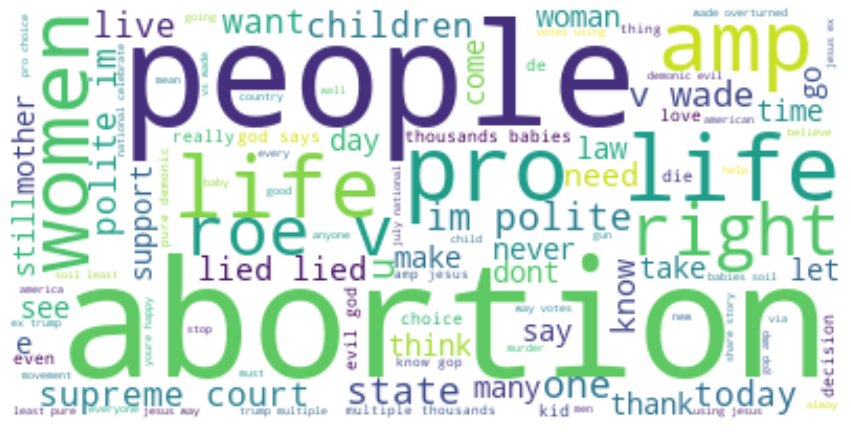

In [42]:
text = " ".join(i for i in data_pos.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

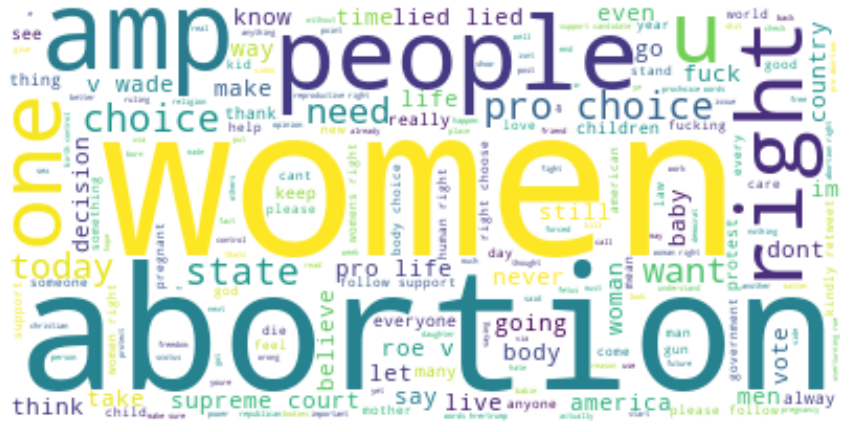

In [43]:
text = " ".join(i for i in data_neg.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Response [200]>
{'status': 'ok', 'totalResults': 13272, 'articles': [{'source': {'id': 'bbc-news', 'name': 'BBC News'}, 'author': 'https://www.facebook.com/bbcnews', 'title': 'Abortion election results: Vermont first to put abortion rights in constitution', 'description': "Four other states have voted on abortion rights - an issue that is close to the top of voters' priorities.", 'url': 'https://www.bbc.co.uk/news/world-us-canada-63564062', 'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/10B4A/production/_127562486_gettyimages-1438480161.jpg', 'publishedAt': '2022-11-09T04:23:06Z', 'content': 'Vermont is set to become the first state in the US to formally enshrine the right to an abortion in the constitution, after more 70% voted in favour of the measure, projections say.\r\nCalifornia, Mont… [+1606 chars]'}, {'source': {'id': 'cnn', 'name': 'CNN'}, 'author': 'Mary Ziegler', 'title': 'Opinion: The biggest lesson of the 2022 midterm election cycle', 'description': "For t

<Response [200]>
{'status': 'ok', 'totalResults': 93, 'articles': [{'source': {'id': 'wired', 'name': 'Wired'}, 'author': 'Omar L. Gallaga', 'title': 'Your Google Searches Are Quietly Evolving. Here’s What’s Next', 'description': 'We went behind the scenes to make sense of Shopping, Ads, and the changes that will shape your internet searches.', 'url': 'https://www.wired.com/story/google-search-shopping-ads-malware-trends/', 'urlToImage': 'https://media.wired.com/photos/6377e13efe38b61aac80e5f5/191:100/w_1280,c_limit/The-Future-of-Google-Search-Gear-GettyImages-1366765218.jpg', 'publishedAt': '2022-11-21T13:00:00Z', 'content': 'Changes to the way Google handles search rankings are intended to push up content from real people, not content farms optimizing content for search engines, and that works in tandem with other effort… [+4763 chars]'}, {'source': {'id': 'the-washington-post', 'name': 'The Washington Post'}, 'author': 'Caroline Kitchener, Kim Bellware, Rachel Roubein', 'title': 'Ab

/var/folders/3l/yzh9j02x7bxd463cl1x0_2lh0000gn/T/ipykernel_26410/4255973473.py:222: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  BBC_DF = pd.read_csv(filename, error_bad_lines=False)
/Users/xingyuchen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0      Four other states have voted abortion rights i...
1      past several weeks pundits warned that Democra...
2      Inflation voters issue Democrats hope anger ov...
3      Paxton Melanie have very different views wheth...
4      Abortion inflation control voting rights some ...
                             ...                        
188    North Carolina seen dramatic increase state re...
189    Content Note Sexual Assault abuse traumatic mi...
190                                                 None
191    Members Diego LGBTQ community shaken after sho...
192    Anti abortion advocates have filed federal law...
Name: Headline, Length: 193, dtype: object
The headline list is:

['Four other states have voted abortion rights issue that close voters priorities', 'past several weeks pundits warned that Democrats peaked early True Americans like Supreme Court decision this summer reverse Wade destroy abortion rights were told that June long time Other', 'Inflation voters issue Democr

            LABEL  abortions  access  anti  ballot  biden  candidates  close  \
100  antiabortion          0       0     0       0      0           0      0   
101  antiabortion          0       0     0       1      0           0      0   
102  antiabortion          0       0     0       0      0           0      0   
103  antiabortion          0       1     0       0      0           0      0   
104  antiabortion          0       0     0       0      0           0      0   
..            ...        ...     ...   ...     ...    ...         ...    ...   
188  antiabortion          1       0     0       0      0           0      0   
189  antiabortion          0       0     0       0      0           0      0   
190  antiabortion          0       0     0       0      0           0      0   
191  antiabortion          0       0     0       0      0           0      0   
192  antiabortion          0       0     2       0      0           0      0   

     constitution  control  ...  suprem

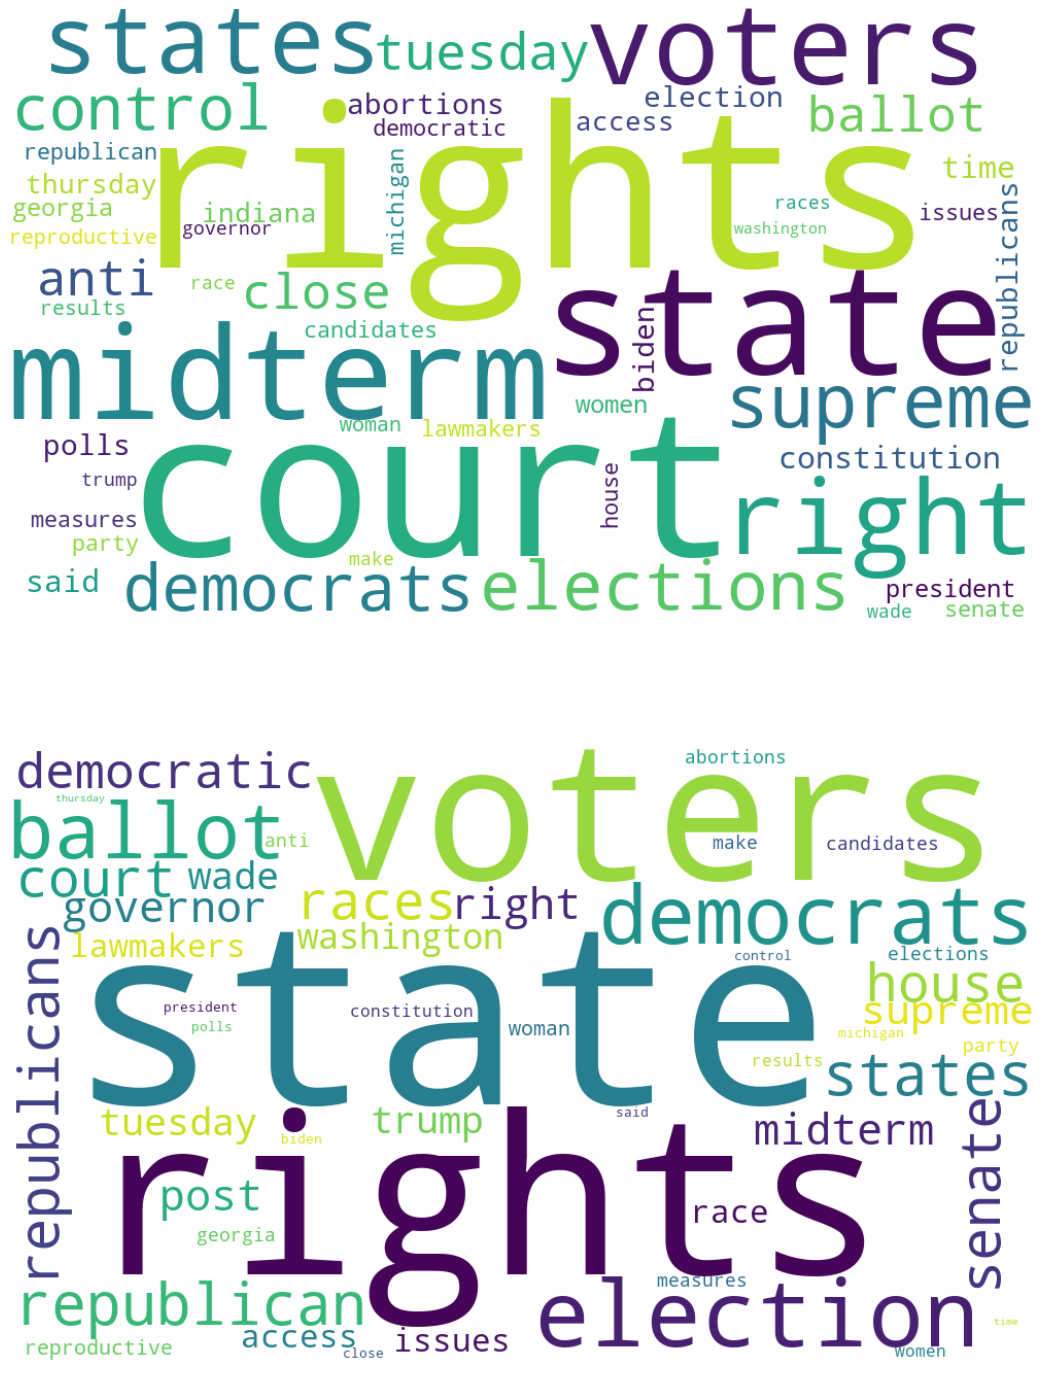

In [66]:
# Data gathering via API - URLs and GET
# Cleaning and preparing text DATA
# DTM and Data Frames
# Training and Testing at DT

#########################################
# https://newsapi.org/ for register an API key
#########################################

# What to import
import requests
import re
import pandas as pd
from pandas import DataFrame

## To tokenize and vectorize text type data
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import random as rd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import graphviz

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn
from sklearn.cluster import KMeans

from sklearn import preprocessing

import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram

topics = ["abortion", "antiabortion"]

filename = "NewHeadlines.csv"
MyFILE = open(filename, "w") 
WriteThis = "LABEL,Date,Source,Title,Headline\n"
MyFILE.write(WriteThis)
MyFILE.close()

#### GATHER - CLEAN - CREATE FILE

endpoint = "https://newsapi.org/v2/everything"

for topic in topics:

    ## Dictionary Structure
    URLPost = {'apiKey': '1df08f5f5fd54b8eb321e7d512acd363',
               'q': topic
               }

    response = requests.get(endpoint, URLPost)
    print(response)
    jsontxt = response.json()
    print(jsontxt)
    
    ## Open the file for append
    MyFILE = open(filename, "a")
    LABEL = topic
    for items in jsontxt["articles"]:
        print(items, "\n\n\n")

        Source = items["source"]["name"]
        print(Source)

        Date = items["publishedAt"]
        ##clean up the date
        NewDate = Date.split("T")
        Date = NewDate[0]
        print(Date)

        ## CLEAN the Title
        ##----------------------------------------------------------
        ##Replace punctuation with space
        # Accept one or more copies of punctuation
        # plus zero or more copies of a space
        # and replace it with a single space
        Title = items["title"]
        Title = str(Title)
        # print(Title)
        Title = re.sub(r'[,.;@#?!&$\-\']+', ' ', str(Title), flags=re.IGNORECASE)
        Title = re.sub(' +', ' ', str(Title), flags=re.IGNORECASE)
        Title = re.sub(r'\"', ' ', str(Title), flags=re.IGNORECASE)

        # and replace it with a single space
        ## NOTE: Using the "^" on the inside of the [] means
        ## we want to look for any chars NOT a-z or A-Z and replace
        ## them with blank. This removes chars that should not be there.
        Title = re.sub(r'[^a-zA-Z]', " ", str(Title), flags=re.VERBOSE)
        Title = Title.replace(',', '')
        Title = ' '.join(Title.split())
        Title = re.sub("\n|\r", "", Title)
        print(Title)
        ##----------------------------------------------------------

        Headline = items["description"]
        Headline = str(Headline)
        Headline = re.sub(r'[,.;@#?!&$\-\']+', ' ', Headline, flags=re.IGNORECASE)
        Headline = re.sub(' +', ' ', Headline, flags=re.IGNORECASE)
        Headline = re.sub(r'\"', ' ', Headline, flags=re.IGNORECASE)
        Headline = re.sub(r'[^a-zA-Z]', " ", Headline, flags=re.VERBOSE)
        ## Be sure there are no commas in the headlines or it will
        ## write poorly to a csv file....
        Headline = Headline.replace(',', '')
        Headline = ' '.join(Headline.split())
        Headline = re.sub("\n|\r", "", Headline)

        ### AS AN OPTION - remove words of a given length............
        Headline = ' '.join([wd for wd in Headline.split() if len(wd) > 3])

        WriteThis = str(LABEL) + "," + str(Date) + "," + str(Source) + "," + str(Title) + "," + str(Headline) + "\n"
        MyFILE.write(WriteThis)

    ## CLOSE THE FILE
    MyFILE.close()

################## END for loop

####################################################
##
## Where are we now?
##
## So far, we have created a csv file
## with labeled data. Each row is a news article
##
## - BUT -
## We are not done. We need to choose which
## parts of this data to use to model our decision tree
## and we need to convert the data into a data frame.
##
########################################################


BBC_DF = pd.read_csv(filename, error_bad_lines=False)
print(BBC_DF.head())
# iterating the columns
for col in BBC_DF.columns:
    print(col)

print(BBC_DF["Headline"])

## REMOVE any rows with NaN in them
BBC_DF = BBC_DF.dropna()
print(BBC_DF["Headline"])

### Tokenize and Vectorize the Headlines
## Create the list of headlines
## Keep the labels!

HeadlineLIST = []
LabelLIST = []

for nexthead, nextlabel in zip(BBC_DF["Headline"], BBC_DF["LABEL"]):
    HeadlineLIST.append(nexthead)
    LabelLIST.append(nextlabel)

print("The headline list is:\n")
print(HeadlineLIST)

print("The label list is:\n")
print(LabelLIST)

##########################################
## Remove all words that match the topics.
## For example, if the topics are food and covid
## remove these exact words.
##
## We will need to do this by hand.
NewHeadlineLIST = []

for element in HeadlineLIST:
    print(element)
    print(type(element))
    ## make into list
    AllWords = element.split(" ")
    print(AllWords)

    ## Now remove words that are in your topics
    NewWordsList = []
    for word in AllWords:
        print(word)
        word = word.lower()
        if word in topics:
            print(word)
        else:
            NewWordsList.append(word)

    ##turn back to string
    NewWords = " ".join(NewWordsList)
    ## Place into NewHeadlineLIST
    NewHeadlineLIST.append(NewWords)

##
## Set the     HeadlineLIST to the new one
HeadlineLIST = NewHeadlineLIST
print(HeadlineLIST)
#########################################
##
##  Build the labeled dataframe
##
######################################################

### Vectorize
## Instantiate your CV
MyCountV = CountVectorizer(
    input="content",  ## because we have a csv file
    lowercase=True,
    stop_words="english",
    max_features=50
)

## Use your CV
MyDTM = MyCountV.fit_transform(HeadlineLIST)  # create a sparse matrix
print(type(MyDTM))

ColumnNames = MyCountV.get_feature_names()
# print(type(ColumnNames))


## Build the data frame
MyDTM_DF = pd.DataFrame(MyDTM.toarray(), columns=ColumnNames)

## Convert the labels from list to df
Labels_DF = DataFrame(LabelLIST, columns=['LABEL'])

## Check your new DF and you new Labels df:
print("Labels\n")
print(Labels_DF)
print("News df\n")
print(MyDTM_DF.iloc[:, 0:6])

##Save original DF - without the lables
My_Orig_DF = MyDTM_DF
print(My_Orig_DF)
######################
## AND - just to make sure our dataframe is fair
## let's remove columns called:
## food, bitcoin, and sports (as these are label names)
######################
# MyDTM_DF=MyDTM_DF.drop(topics, axis=1)


## Now - let's create a complete and labeled
## dataframe:
dfs = [Labels_DF, MyDTM_DF]
print(dfs)

Final_News_DF_Labeled = pd.concat(dfs, axis=1, join='inner')
## DF with labels
print(Final_News_DF_Labeled)

#############################################
##
## Create Training and Testing Data
##
## Then model and test the Decision Tree
##
################################################


##--------------------------------------------------------
List_of_WC = []

for mytopic in topics:
    tempdf = Final_News_DF_Labeled[Final_News_DF_Labeled['LABEL'] == mytopic]
    print(tempdf)

    tempdf = tempdf.sum(axis=0, numeric_only=True)
    # Make var name
    NextVarName = str("wc" + str(mytopic))
    # print( NextVarName)

    ## https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

    ###########
    ## Create and store in a list the wordcloud OBJECTS
    #########
    NextVarName = WordCloud(width=1000, height=600, background_color="white",
                            min_word_length=4,  # mask=next_image,
                            max_words=400).generate_from_frequencies(tempdf)

    ## Here, this list holds all three wordclouds I am building
    List_of_WC.append(NextVarName)

##------------------------------------------------------------------
print(List_of_WC)
##########
########## Create the wordclouds
##########
fig = plt.figure(figsize=(25, 25))
# figure, axes = plt.subplots(nrows=2, ncols=2)
NumTopics = len(topics)
for i in range(NumTopics):
    print(i)
    ax = fig.add_subplot(NumTopics, 1, i + 1)
    plt.imshow(List_of_WC[i], interpolation='bilinear')
    plt.axis("off")
    plt.savefig("NewClouds.pdf")

In [67]:
print(My_Orig_DF)

     abortions  access  anti  ballot  biden  candidates  close  constitution  \
0            0       0     0       0      0           0      1             0   
1            0       0     0       0      0           0      0             0   
2            0       0     0       0      0           0      0             0   
3            0       0     0       0      0           0      0             0   
4            0       0     0       0      0           0      0             0   
..         ...     ...   ...     ...    ...         ...    ...           ...   
188          1       0     0       0      0           0      0             0   
189          0       0     0       0      0           0      0             0   
190          0       0     0       0      0           0      0             0   
191          0       0     0       0      0           0      0             0   
192          0       0     2       0      0           0      0             0   

     control  court  ...  supreme  thur

In [68]:
print(Labels_DF)

            LABEL
0        abortion
1        abortion
2        abortion
3        abortion
4        abortion
..            ...
188  antiabortion
189  antiabortion
190  antiabortion
191  antiabortion
192  antiabortion

[193 rows x 1 columns]


In [69]:
training_data = My_Orig_DF

In [70]:
train_labels = pd.factorize(Labels_DF['LABEL'])[0]
train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [71]:
NumCols = Final_News_DF_Labeled.shape[1]
print(NumCols)

51


In [72]:
###############################
## ANN
#################################
## Simple Dense NN for sentiment analysis (classification 0 neg, 1 pos)
# First layer: Embedding Layer (Keras Embedding Layer) that will learn embeddings 
# for different words .
## RE: ## https://keras.io/api/layers/core_layers/embedding/
## input_dim: Integer. Size of the vocabulary
## input_length: Length of input sequences, when it is constant.
print(NumCols)   
input_dim = NumCols + 1 
 #https://www.tensorflow.org/api_docs/python/tf/keras/Input
input_data = tensorflow.keras.layers.Input(shape=(50))
 #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=18, input_length=50)(input_data)
##input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1
## Good tutorial for this concept:
    ## https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
 #output_dim: Integer. Dimension of the dense embedding.
 # output_dim: This is the size of the vector space in which words will be embedded. 
 #It defines the size of the output vectors from this layer for each word. 
 # For example, it could be 32 or 100 or even larger.
 #https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#  In an embedding, words are represented by dense vectors where a vector represents 
#  the projection of the word into a continuous vector space.
# The position of a word within the vector space is learned 
# from text and is based on the words that surround the word when it is used.
# The position of a word in the learned vector space is referred to as its embedding.
data = tensorflow.keras.layers.Flatten()(data)
 #Dense layers require inputs as (batch_size, input_size) 
data = tensorflow.keras.layers.Dense(16)(data)
data = tensorflow.keras.layers.Activation('relu')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(8)(data)
data = tensorflow.keras.layers.Activation('relu')(data)

data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(4)(data)
data = tensorflow.keras.layers.Activation('sigmoid')(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10)

51
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 50, 18)            936       
                                                                 
 flatten_6 (Flatten)         (None, 900)               0         
                                                                 
 dense_24 (Dense)            (None, 16)                14416     
                                                                 
 activation_21 (Activation)  (None, 16)                0         
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 8)                 

In [73]:

###################################
## RNN
###############################################
 
input_data = tensorflow.keras.layers.Input(shape=(50))
 
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=50)(input_data)
 #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.SimpleRNN(50))(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 50, 32)            1664      
                                                                 
 bidirectional_6 (Bidirectio  (None, 100)              8300      
 nal)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 101       
                                                                 
 activation_25 (Activation)  (None, 1)                 0         
                                                                 
Total params: 10,065
Trainable params: 10,065
Non-trainable params: 0
______________________________________________________

In [74]:

############################################
## LSTM
#############################################
input_data = tensorflow.keras.layers.Input(shape=(50))
 
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=50)(input_data)
 
data = tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(50))(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10)


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 50, 32)            1664      
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              33200     
 nal)                                                            
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
 activation_26 (Activation)  (None, 1)                 0         
                                                                 
Total params: 34,965
Trainable params: 34,965
Non-trainable params: 0
______________________________________________________

In [75]:

######################################
## CNN
########################################
input_data = tensorflow.keras.layers.Input(shape=(50))
 
data = tensorflow.keras.layers.Embedding(input_dim=input_dim, output_dim=32, input_length=50)(input_data)
 
data = tensorflow.keras.layers.Conv1D(50, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Conv1D(40, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Conv1D(30, kernel_size=3, activation='relu')(data)
data = tensorflow.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tensorflow.keras.layers.Flatten()(data)
 
data = tensorflow.keras.layers.Dense(20)(data)
data = tensorflow.keras.layers.Dropout(0.5)(data)
 
data = tensorflow.keras.layers.Dense(1)(data)
output_data = tensorflow.keras.layers.Activation('sigmoid')(data)
 
model = tensorflow.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

model.fit(training_data, train_labels, epochs=10)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 50, 32)            1664      
                                                                 
 conv1d_12 (Conv1D)          (None, 48, 50)            4850      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 24, 50)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 22, 40)            6040      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 11, 40)           0         
 g1D)                                                     

In [65]:
## Previous simple Neural nets 

# # softmax, hot coding, cross entropy

# import numpy as np
# import pandas as pd

# # Using a dataset with THREE label categories, 1, 2, and 3---------------
# filename = "./data/clean.csv"
# DF = pd.read_csv(str(filename))
# print(DF.head())
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(DF, test_size=0.33)
# # n = len(DF)  # number of rows of entire X
# n = len(train)
# # Take the label off of X and make it a numpy array
# TrainLabel = train["target"]
# X = np.array(train.drop('target', axis=1))
# # Set y to the label. Check the shape!
# y = np.array(TrainLabel).T
# y = np.array([y]).T
# print("y is\n", y)
# LR = .01
# LRB = .01
# # ................................................
# # -*- coding: utf-8 -*-
# """
# author: Xingyu Chen
# """

# import numpy as np
# import matplotlib.pyplot as plt


# class neural_nets(object):

#     @staticmethod
#     def Sigmoid(value, deriva=False):
#         if deriva:
#             return value * (1 - value)
#         return 1 / (1 + np.exp(-value))

#     def __init__(self, X, y, bs, c, W1_x, W2_h):
#         self.LR = 0.01
#         self.X = X
#         self.y = y

#         self.bs = bs
#         self.c = c
#         self.W1_x = W1_x
#         self.W2_h = W2_h

#         self.z = None
#         self.h = None
#         self.z2 = None

#         self.GA = False

#     def train(self, X, y):
#         output = self.FeedForward(X)
#         self.BackProp(X, y, output)
#         return output

#     def FeedForward(self, X):
#         # print("FeedForward:\n")
#         self.z = (np.dot(X, self.W1_x)) + self.bs # X is n by c   W1  is c by h -->  n by h
#         # print("Z1 is:\n", self.z)
#         self.h = self.Sigmoid(self.z)  # activation function    shape: n by h
#         # print("H is:\n", self.h)
#         self.z2 = (np.dot(self.h, self.W2_h)) + self.c  # n by h  @  h by o  -->  n by o
#         # print("Z2 is:\n", self.z2)
#         output = self.Sigmoid(self.z2)
#         # print("y^ is:\n", output)
#         return output

#     def BackProp(self, X, y, output):
#         # print("\nBackProp:\n")
#         # Y^ - Y
#         self.output_error = output - y
#         # print("Y^ - Y\n", self.output_error)
#         # print("SIG Y^\n", self.Sigmoid(output, deriva=True))

#         # (Y^ - Y)(Y^)(1-Y^)
#         self.output_delta = self.output_error * self.Sigmoid(output, deriva=True)
#         # print("D_Error (Y^)(1-Y^)(Y^-Y) is:\n", self.output_delta)

#         # (Y^ - Y)(Y^)(1-Y^)(W2)
#         self.D_Error_W2 = self.output_delta.dot(self.W2_h.T)  # D_Error times W2
#         # print("W2 is\n", self.W2)
#         # print(" D_Error times W2\n", self.D_Error_W2)

#         # (H)(1 - H) (Y^ - Y)(Y^)(1-Y^)(W2)
#         self.H_D_Error_W2 = self.D_Error_W2 * self.Sigmoid(self.h, deriva=True)
#         # Note that * will multiply respective values together in each matrix

#         # print("Derivative sig H is:\n", self.Sigmoid(self.h, deriva=True))
#         # print("self.H_D_Error_W2 is\n", self.H_D_Error_W2)

#         # ------UPDATE weights and biases ------------------

#         #  XT  (H)(1 - H) (Y^ - Y)(Y^)(1-Y^)(W2)
#         self.X_H_D_Error_W2 = X.T.dot(self.H_D_Error_W2)  # this is dW1

#         # (H)T (Y^ - Y)(Y^)(1-Y^)
#         self.h_output_delta = self.h.T.dot(self.output_delta)  # this is dW2

#         # print("the gradient :\n", self.X_H_D_Error_W2)
#         # print("the gradient average:\n", self.X_H_D_Error_W2/self.n)

#         if self.GA == "True":
#             print("Using average gradient........\n")
#             # self.W1_x = self.W1_x - self.LR * (self.X_H_D_Error_W2 / 3)
#             # self.W2_h = self.W2_h - self.LR * (self.h_output_delta / 3)  ## average the gradients
#         # #print("New W1: \n", self.W1)
#         else:
#             # print("Using sum gradient........\n")
#             self.W1_x = self.W1_x - self.LR * self.X_H_D_Error_W2  # c by h first set (input -> hidden) weights
#             self.W2_h = self.W2_h - self.LR * self.h_output_delta  # adjusting second set (hidden -> output) weights
#         # print("New W1: \n", self.W1_x)
#         # print("New W2: \n", self.W2_h)
#         # print("The b biases before the update are:\n", self.bs)
#         self.bs = self.bs - self.LR * self.H_D_Error_W2
#         # print("The H_D_Error_W2 is...\n", self.H_D_Error_W2)
#         # print("Updated bs are:\n", self.bs)

#         self.c = self.c - self.LR * self.output_delta
#         # print("Updated c's are:\n", self.c)

#         # # print("The W1 is: \n", self.W1_x)
#         # print("The W1 gradient is: \n", self.X_H_D_Error_W2)
#         # # print("The W1 gradient average is: \n", self.X_H_D_Error_W2/self.n)
#         # print("The W2 gradient  is: \n", self.h_output_delta)
#         # # print("The W2 gradient average is: \n", self.h_output_delta/self.n)
#         # print("The biases b gradient is:\n", self.H_D_Error_W2)
#         # print("The bias c gradient is: \n", self.output_delta)


# # Set up
# # X = np.array([[1, 2, 3], [-1, -2, -3], [3, 4, -2]])
# #
# # y = np.array([[1], [0], [0]])
# #
# # W1_x = np.array([[1, -1], [2, -2], [3, -3]])
# #
# # bs = np.array([[1, 2]])
# #
# # W2_h = np.array([[4], [5]])
# #
# # c = 3
# InputNumColumns = 5  # columns
# OutputSize = 1  # Categories
# HiddenUnits = 5  # one layer with h units
# # n = n  # number of training examples, n
# print("Initialize NN\n")
# # Random W1
# W1_x = np.random.randn(InputNumColumns, HiddenUnits)  # c by h

# print("INIT W1 is\n", W1_x)

# # -----------------------------------------
# # NOTE #
# #
# # The following are all random. However, you can comment this out
# # and can set any weights and biases by hand , etc.
# #
# # ---------------------------------------------

# W2_h = np.random.randn(HiddenUnits, OutputSize)  # h by o
# print("W2 is:\n", W2_h)

# bs = np.random.randn(1, HiddenUnits)
# print("The b's are:\n", bs)
# # biases for layer 1
# c = np.random.randn(1, OutputSize)
# print("The c is\n", c)
# # bias for last layer

# # Initial
# NN = neural_nets(X, y, bs, c, W1_x, W2_h)

# TotalLoss = []
# AverageLoss = []
# Epochs = 1000

# for i in range(Epochs):
#     print("Iteration ", i + 1)
#     output = NN.train(X, y)

#     print("Total Loss:", .5 * (np.sum(np.square(output - y))))
#     TotalLoss.append(.5 * (np.sum(np.square(output - y))))

#     print("Average Loss:", .5 * (np.mean(np.square((output - y)))))
#     AverageLoss.append(.5 * (np.mean(np.square((output - y)))))


# TestLabel = test["target"]
# test = test.drop('target', axis=1)

# ## COnfusion Matrix Accuracies
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# # print(y)
# # print(np.round(output))
# # print("\nThe true test labels are:")
# # print(TestLabel)
# # print("\nThe predict test labels are:")
# # print(NN.FeedForward(test))
# # cnf_matrix = confusion_matrix(TestLabel, np.round(NN.FeedForward(test)))
# cnf_matrix = confusion_matrix(y, np.round(output))
# print("\nThe confusion matrix is:")
# print(cnf_matrix)

# cnf = accuracy_score(y, np.round(output))
# print("\nThe accuracy score is:")
# print(cnf)
# # Plot

# fig1 = plt.figure()
# ax = plt.axes()
# x = np.linspace(0, 1000, Epochs)
# ax.plot(x, TotalLoss)
# plt.show()

# fig2 = plt.figure()
# ax = plt.axes()
# x = np.linspace(0, 1000, Epochs)
# ax.plot(x, AverageLoss)
# plt.show()
